In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from scipy.io import loadmat
from scipy.interpolate import griddata
from matplotlib import cm
from skimage import exposure
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models, utils, optimizers
import time

C:\Users\Sumukh P Shetty\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Sumukh P Shetty\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Sumukh P Shetty\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
!pip install tensorflow


In [3]:
# === Helper function to recursively convert mat_struct to dictionary ===
def _check_keys(d):
    for key in d:
        if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
            d[key] = _todict(d[key])
    return d

def _todict(matobj):
    d = {}
    for strg in matobj._fieldnames:
        elem = getattr(matobj, strg)
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            d[strg] = _todict(elem)
        else:
            d[strg] = elem
    return d

In [4]:
# === Load the .mat file ===
file_path = "C:/Users/Sumukh P Shetty/Downloads/archive (3)/BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat"
mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
mat_data = _check_keys(mat_data)

C:\Users\Sumukh P Shetty\AppData\Local\Temp\ipykernel_11848\1956363914.py:4: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
C:\Users\Sumukh P Shetty\AppData\Local\Temp\ipykernel_11848\1956363914.py:12: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):


In [5]:
# === Access the contents ===
epo_train = mat_data['epo_train']
mnt = mat_data['mnt']

# === Accessing epo_train fields
data = epo_train['x']           # EEG data: shape (samples, channels, trials)
labels = epo_train['y']         # Labels: shape (num_classes, trials)

# === Accessing mnt fields (channel positions)
mnt_x = mnt['x'][0]             # x-coordinates: (64,)
mnt_y = mnt['y'][0]             # y-coordinates: (64,)

In [6]:
# Example access:
print("epo_train keys:", epo_train.keys())
print("mnt keys:", mnt.keys())

epo_train keys: dict_keys(['clab', 'fs', 'title', 'file', 'x', 'y', 't', 'className'])
mnt keys: dict_keys(['x', 'y', 'pos_3d', 'clab'])


In [7]:
# === Channel Labeling ===
label_to_channel = {
    'Fp1': 1, 'Fp2': 2, 'F7': 3, 'F3': 4, 'Fz': 5, 'F4': 6,
    'F8': 7, 'FC5': 8, 'FC1': 9, 'FC2': 10, 'FC6': 11, 'T7': 12,
    'C3': 13, 'Cz': 14, 'C4': 15, 'T8': 16, 'TP9': 17, 'CP5': 18,
    'CP1': 19, 'CP2': 20, 'CP6': 21, 'TP10': 22, 'P7': 23, 'P3': 24,
    'Pz': 25, 'P4': 26, 'P8': 27, 'PO9': 28, 'O1': 29, 'Oz': 30,
    'O2': 31, 'PO10': 32, 'AF7': 33, 'AF3': 34, 'AF4': 35, 'AF8': 36,
    'F5': 37, 'F1': 38, 'F2': 39, 'F6': 40, 'FT9': 41, 'FT7': 42,
    'FC3': 43, 'FC4': 44, 'FT8': 45, 'FT10': 46, 'C5': 47, 'C1': 48,
    'C2': 49, 'C6': 50, 'TP7': 51, 'CP3': 52, 'CPz': 53, 'CP4': 54,
    'TP8': 55, 'P5': 56, 'P1': 57, 'P2': 58, 'P6': 59, 'PO7': 60,
    'PO3': 61, 'POz': 62, 'PO4': 63, 'PO8': 64
}


# 14 Channels available by EMOTIV EPOC headset
Channels1 = ["AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"]  

# 15 Channels - Research [14] claimed these brain regions are significantly associated with imagined speech
Channels2 = ["AF3","F7","F3","F4","F8","AF4","AF7","AF8","Fp1","Fp2","F2","F6","Fz","F1","F5"] 

# Left-Hemisphere Dominance in Language Processing
Channels3 = ["F7","F3","FC5","T7","P7","C3"]  

# Subject-Specific Channel Selection Using Utility Metrics
Channels4 = ["F7","F3","FC5","FC6","F4","T7","T8","C3","C4","P7","P8","O1","O2","CP5","CP6","Cz","P3","P4","POz"]  

# Targeting Frontal and Central Regions
Channels5 = ["F3","FC5","C3","F4","FC6","C4","Cz"]  

In [8]:
# === Parameters ===
fs = 256               # Sampling frequency (Hz)
win_ms = 125           # Window length (milliseconds)
overlap_percent = 50   # Desired overlap (in percentage)

# === Calculations ===
win_samples = round(fs * win_ms / 1000)                      # Samples per window
overlap_samples = round(win_samples * overlap_percent / 100)  # Overlap samples
step_samples = win_samples - overlap_samples                 # Step size
total_samples = epo_train['x'].shape[0]  # Total time samples (e.g., 795)


n_maps = int(np.floor((total_samples - overlap_samples) / step_samples))  # Number of windows/maps

In [9]:
# == Selecting the Channels ==

# Select the channel
selected = Channels4 # Select which channel group you would like to use 

# Preallocate
selected_channels = np.zeros(len(selected), dtype=int)

# Map each label to its corresponding index using the dictionary
for i in range(len(selected)):
    selected_channels[i] = label_to_channel[selected[i]]

In [10]:
# === MAP PARAMETERS ===
map_size = 32

# Select x and y coordinates for selected channels
x_sel = mnt['x'][selected_channels]
y_sel = mnt['y'][selected_channels]

# Create meshgrid for interpolation
xi, yi = np.meshgrid(
    np.linspace(np.min(x_sel), np.max(x_sel), map_size),
    np.linspace(np.min(y_sel), np.max(y_sel), map_size)
)

# Range of maps
start_map = 1
end_map = 48
tot_map = end_map - start_map + 1

# Number of training trials
n_train_trials = epo_train['x'].shape[2]  # assuming shape is [time, channels, trials]

In [11]:
# === Notch Filter Parameters ===
fs = 256  # Sampling frequency
f0 = 40   # Notch frequency
Q = 35    # Quality factor

# === Compute filter coefficients for notch filter ===
w0 = 2 * np.pi * f0 / fs
alpha = np.sin(w0) / (2 * Q)

b_notch = np.array([1, -2 * np.cos(w0), 1]) / (1 + alpha)
a_notch = np.array([1 + alpha, -2 * np.cos(w0), 1 - alpha]) / (1 + alpha)

# === Copy data to preserve original
all_data = epo_train['x']  # shape: (samples, channels, trials)
filtered_data = np.copy(all_data)

# === Apply notch filter channel-by-channel and trial-by-trial
n_trials = filtered_data.shape[2]
n_channels = filtered_data.shape[1]

for t in range(n_trials):
    for ch in range(n_channels):
        signal = filtered_data[:, ch, t]
        filtered_data[:, ch, t] = filtfilt(b_notch, a_notch, signal)

# === Apply CAR referencing (per trial)
for t in range(n_trials):
    trial = filtered_data[:, :, t]
    trial = trial - np.mean(trial, axis=1, keepdims=True)
    filtered_data[:, :, t] = trial

# === Save back to structure
epo_train_car = dict(epo_train)  # Clone the structure
epo_train_car['x'] = filtered_data  # Update with filtered and CAR-applied data

In [13]:
import numpy as np
from matplotlib import colormaps
from scipy.interpolate import griddata

# === Initialize Parameters ===
map_size = xi.shape[0]  # Assuming xi is a square 2D grid (like 64x64)
topo_maps_rgb_5D = np.zeros((map_size, map_size, 3, n_maps, n_train_trials))  # [H x W x 3 x T x N]

# Load the colormap using modern Matplotlib API
cmap = colormaps['jet']

# === Main Loop Over Trials ===
for t in range(n_train_trials):
    # Extract 2D data: [time x selected_channels]
    data = epo_train_car['x'][:, selected_channels, t]

    for w in range(n_maps):
        # Calculate start and end indices for time window
        start_idx = w * step_samples
        end_idx = start_idx + win_samples

        # Skip if window exceeds total samples
        if end_idx > total_samples:
            break

        # 1. Compute mean EEG signal over the window → [1 x channels]
        segment = np.mean(data[start_idx:end_idx, :], axis=0).astype(np.float64).flatten()

        # 2. Interpolate the 1D vector onto a 2D grid
        zi = griddata((x_sel.flatten(), y_sel.flatten()), segment, (xi, yi), method='cubic')

        # Handle NaNs if any interpolation failed
        zi = np.nan_to_num(zi, nan=0.0)

        # 3. Normalize zi to [0, 1]
        zi_min, zi_max = np.min(zi), np.max(zi)
        zi_norm = (zi - zi_min) / (zi_max - zi_min + np.finfo(float).eps)

        # 4. Map normalized values to RGB using the colormap
        rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]  # Drop alpha channel

        # 5. Store the resulting RGB map
        topo_maps_rgb_5D[:, :, :, w, t] = rgb_map

# === Final reshape for CNN input ===
# Select only the maps you want
topo_maps_rgb_5D = topo_maps_rgb_5D[:, :, :, start_map - 1:end_map, :]
tot_map = end_map - start_map + 1

# Reshape to: [H x W x 3 x tot_map x num_trials]
topo_maps_rgb_5D = topo_maps_rgb_5D.reshape((map_size, map_size, 3, tot_map, -1))


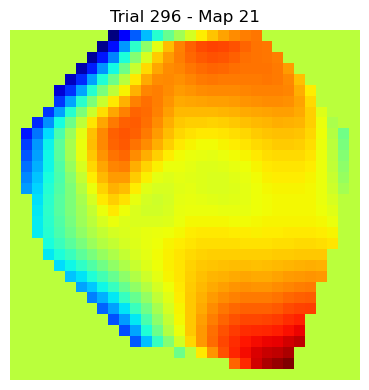

In [14]:
import random

# === Get shape information
H, W, _, T, N = topo_maps_rgb_5D.shape

# === Select a random trial and map index
random_trial = random.randint(0, N - 1)
random_map = random.randint(0, T - 1)

# === Extract the specific map
img = topo_maps_rgb_5D[:, :, :, random_map, random_trial]

# === Plot the selected map
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Trial {random_trial + 1} - Map {random_map + 1}')
plt.axis('off')
plt.tight_layout()
plt.show()

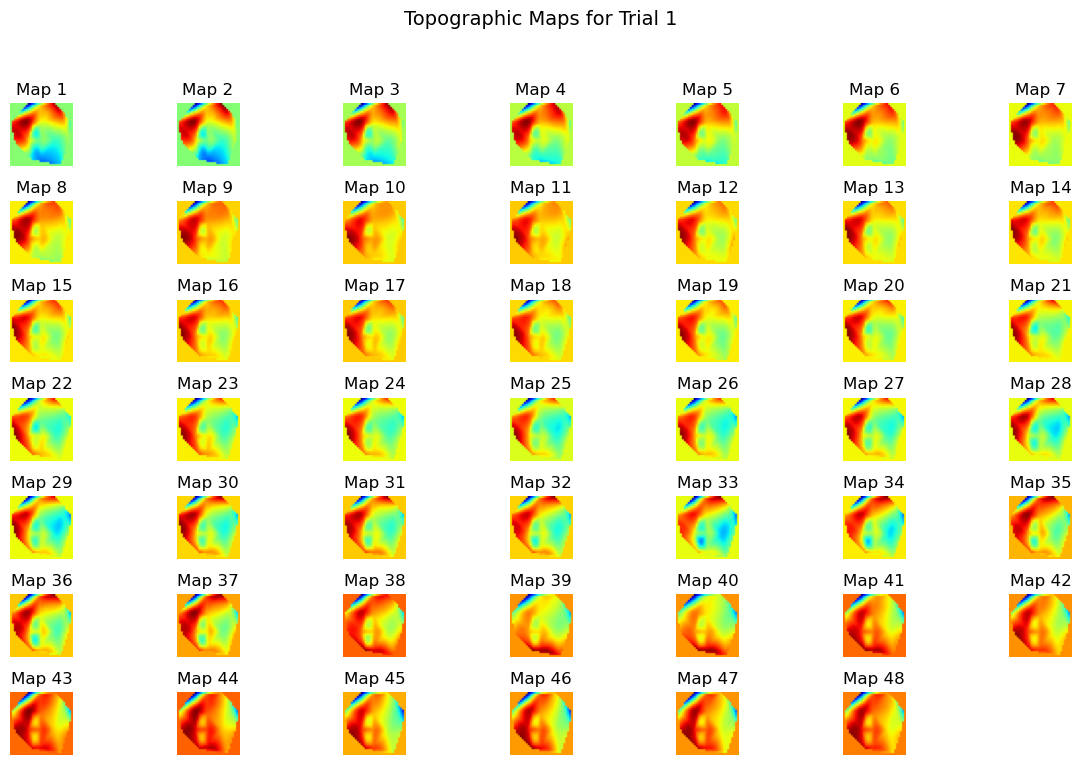

In [15]:
# Parameters
sample_trial = 0  # Python uses 0-based indexing (0 to N-1)
H, W, _, T, N = topo_maps_rgb_5D.shape

if sample_trial < 0 or sample_trial >= N:
    raise ValueError(f"Invalid trial index. Must be between 0 and {N-1}")

# Plotting
plt.figure(figsize=(12, 8))
plt.suptitle(f'Topographic Maps for Trial {sample_trial + 1}', fontsize=14)

cols = int(np.ceil(np.sqrt(T)))
rows = int(np.ceil(T / cols))

for i in range(T):
    plt.subplot(rows, cols, i + 1)
    img = topo_maps_rgb_5D[:, :, :, i, sample_trial]
    plt.imshow(img)
    plt.title(f'Map {i + 1}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [16]:
# Assuming 'epo_train' is a dictionary and 'y' is a numpy array with shape (5, 300)
label_vector = epo_train['y']  # shape: (5, 300)

# === Validate shape
assert label_vector.shape[0] == 5, "Expected 5 rows for one-hot classes."
n_samples = label_vector.shape[1]

# === Convert from one-hot to class indices [0–4]
label_idx = np.argmax(label_vector, axis=0)  # shape: (300,)

# === Class names (adjust if different)
classNames = np.array(["Hello", "Help me", "Stop", "Thank you", "Yes"])

# === Create categorical label vector
labels = pd.Categorical(classNames[label_idx])

In [17]:
# === Input shape and class count
inputSize = (map_size, map_size, 3, tot_map)  # [H, W, C, T]
numClasses = len(np.unique(labels))

# === Define 3D-CNN model
model = models.Sequential([
    layers.InputLayer(input_shape=inputSize),                       # [H, W, C, T]

    layers.Conv3D(32, 3, padding='same', activation='relu'),        # 3D conv over space + time
    layers.MaxPooling3D(pool_size=(2, 2, 1)),                       # Pool over H x W only

    layers.Conv3D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling3D(pool_size=(2, 2, 1)),

    layers.Conv3D(128, 3, padding='same', activation='relu'),
    
    layers.Permute((4, 1, 2, 3)),                                   # Now shape = [T, H', W', C]
    layers.TimeDistributed(layers.Flatten()),                      # Flattens each time slice
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),                      # BiLSTM over time dimension

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(numClasses, activation='softmax')
])
# === Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\Sumukh P Shetty\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
!pip install pydot
!pip install graphviz

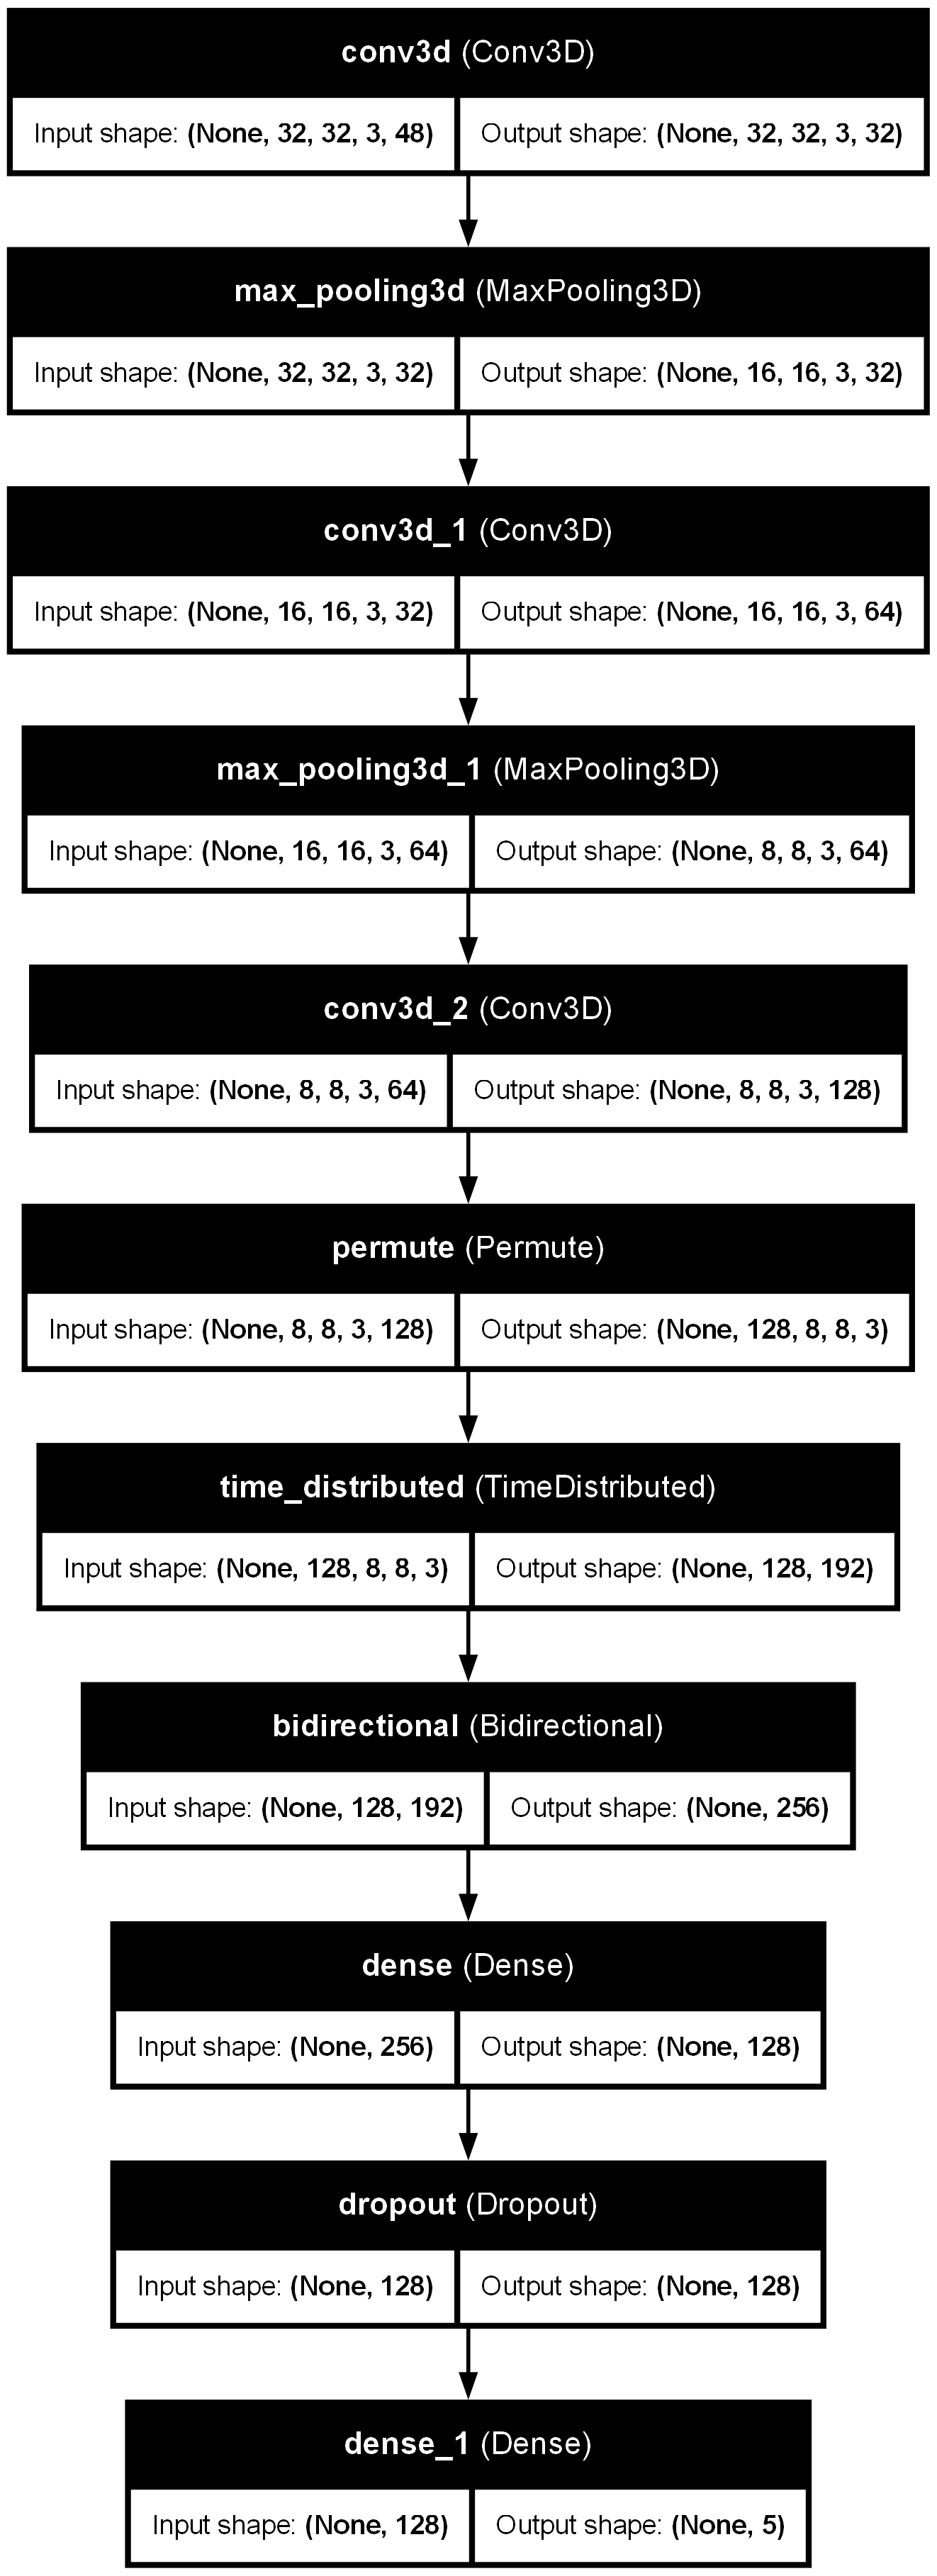

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 32, 32, 3, 32)  │        41,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 3, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 16, 3, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 3, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 8, 3, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 128, 8, 8, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 680,421 (2.60 MB)

 Trainable params: 680,421 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# === Label Preparation
label_indices = utils.to_categorical(
    [np.where(classNames == label)[0][0] for label in labels],
    numClasses
)

# === Data reshaping: [N, H, W, C, T]
topo_maps = np.transpose(topo_maps_rgb_5D, (4, 0, 1, 2, 3))

# === Cross-validation setup
allYPred = []
allYTrue = []
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracy_per_fold = []

totalTime = time.time()

for fold, (trainIdx, testIdx) in enumerate(kf.split(topo_maps)):
    foldTime = time.time()

    # Split data
    XTrain_full, XVal_fold = topo_maps[trainIdx], topo_maps[testIdx]
    YTrain_full, YVal_fold = label_indices[trainIdx], label_indices[testIdx]

    # Further split for internal validation
    val_split = int(0.2 * len(XTrain_full))
    XVal_internal = XTrain_full[:val_split]
    YVal_internal = YTrain_full[:val_split]
    XTrain = XTrain_full[val_split:]
    YTrain = YTrain_full[val_split:]

    # === Train model
    model.fit(
        XTrain, YTrain,
        validation_data=(XVal_internal, YVal_internal),
        batch_size=32,
        epochs=150,
        verbose=0
    )

    # === Evaluate fold
    YPred = np.argmax(model.predict(XVal_fold), axis=1)
    YTrue = np.argmax(YVal_fold, axis=1)

    acc = np.mean(YPred == YTrue)
    accuracy_per_fold.append(acc)
    allYPred.extend(YPred)
    allYTrue.extend(YTrue)

    print(f"Fold {fold+1} Accuracy: {acc*100:.2f}% | Time: {time.time()-foldTime:.2f} seconds")

# === Final summary
totalElapsed = time.time() - totalTime
print(f"\nCross-Validation Average Accuracy: {np.mean(accuracy_per_fold)*100:.2f}%")
print(f"Total Training Time: {totalElapsed:.2f} seconds ({totalElapsed/60:.2f} minutes)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Fold 1 Accuracy: 33.33% | Time: 1130.02 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Fold 2 Accuracy: 90.00% | Time: 444.63 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Fold 3 Accuracy: 80.00% | Time: 229.02 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Fold 4 Accuracy: 86.67% | Time: 236.48 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Fold 5 Accuracy: 86.67% | Time: 231.92 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Fold 6 Accuracy: 96.67% | Time: 235.05 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Fold 7 Accuracy: 86.67% | Time: 235.65 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Fold 8 Accuracy: 86.67% | Time: 235.64 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Fold 9 Accuracy: 83.33% | Time: 237.57 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Fold 10 Accuracy: 86.67% | Time: 235.40 seconds

Cross-Validation Average Accuracy: 81.67%
Total Training Time: 3451.38 seconds (57.52 minutes)


<Figure size 800x600 with 0 Axes>

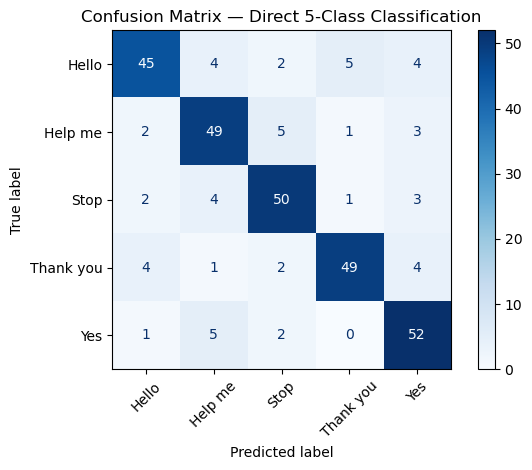

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(allYTrue, allYPred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — Direct 5-Class Classification")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

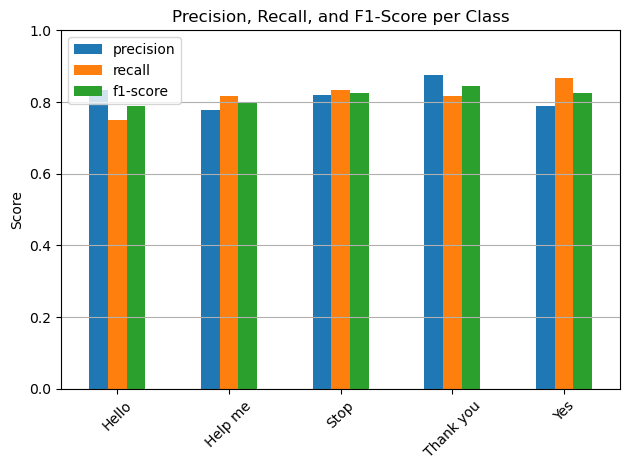

In [22]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Generate classification report as dictionary
report = classification_report(allYTrue, allYPred, target_names=classNames, output_dict=True)

# Convert to DataFrame for plotting
df_report = pd.DataFrame(report).transpose()

# Drop overall metrics (support, accuracy, macro avg, weighted avg)
df_report_classes = df_report.iloc[:-3]

# Plot Precision, Recall, F1-Score per class
plt.figure(figsize=(10, 5))
df_report_classes[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Extract macro and weighted averages
macro_avg = df_report.loc["macro avg", ["precision", "recall", "f1-score"]]
weighted_avg = df_report.loc["weighted avg", ["precision", "recall", "f1-score"]]

# Display in a simple table
summary_df = pd.DataFrame({
    "Macro Average": macro_avg,
    "Weighted Average": weighted_avg
})

display(summary_df.round(3))

,Macro Average,Weighted Average
precision,0.819,0.819
recall,0.817,0.817
f1-score,0.817,0.817


In [24]:
import numpy as np

# cm is your confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for cls, acc in zip(classNames, class_accuracy):
    print(f"{cls}: {acc*100:.2f}%")


Hello: 75.00%
Help me: 81.67%
Stop: 83.33%
Thank you: 81.67%
Yes: 86.67%


In [25]:
from sklearn.metrics import classification_report, accuracy_score

# === Basic Accuracy
overall_accuracy = accuracy_score(allYTrue, allYPred) * 100
print(f"\n✅ Final Cross-Validation Accuracy: {overall_accuracy:.2f}%")

# === Detailed Metrics
report = classification_report(allYTrue, allYPred, target_names=classNames, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# === Extract macro and weighted averages
macro_avg = df_report.loc["macro avg"]
weighted_avg = df_report.loc["weighted avg"]

print("\n📊 Macro Average Metrics:")
print(macro_avg[["precision", "recall", "f1-score"]].round(3))

print("\n📊 Weighted Average Metrics:")
print(weighted_avg[["precision", "recall", "f1-score"]].round(3))

# === Optional: save report to CSV
# df_report.to_csv("classification_report.csv")


✅ Final Cross-Validation Accuracy: 81.67%

📊 Macro Average Metrics:
precision    0.819
recall       0.817
f1-score     0.817
Name: macro avg, dtype: float64

📊 Weighted Average Metrics:
precision    0.819
recall       0.817
f1-score     0.817
Name: weighted avg, dtype: float64


In [26]:
model.save("3DCNN_BI-LSTM.h5")


C:\Users\Sumukh P Shetty\AppData\Local\Temp\ipykernel_10168\2378348285.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', 256)
C:\Users\Sumukh P Shetty\AppData\Local\Temp\ipykernel_10168\2378348285.py:44: RuntimeWarning: invalid value encountered in cast
  rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
🎯 Predicted Class for Trial 17: **Thank you**


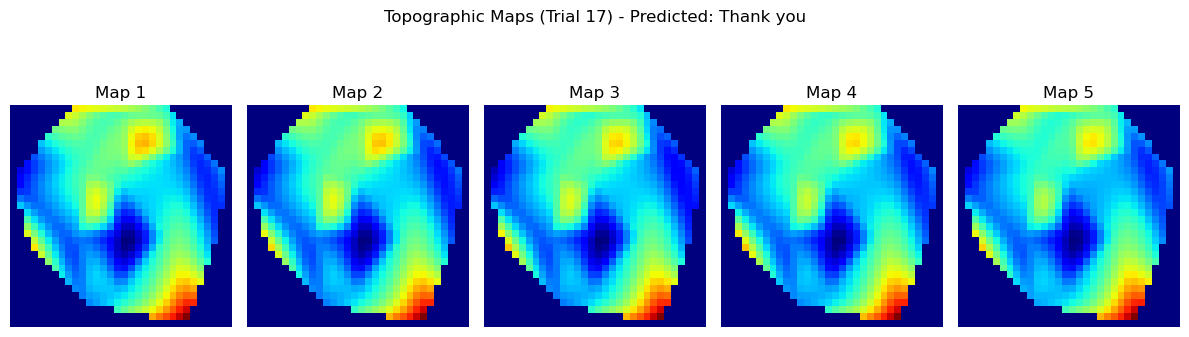

In [28]:
import h5py
import random
from matplotlib import cm  # ✅ this gives access to cm.get_cmap()

from tensorflow.keras.models import load_model  # ✅ Import the loader

# === Load the trained model (.h5 file saved previously)
model = load_model("3DCNN_BI-LSTM.h5")  # ✅ update with actual path if different

# === Select the subject number used in training (same as before)
subject_id = 1  # e.g., 1 for Data_Sample01
file_path = f"C:/Users/Sumukh P Shetty/Downloads/archive (3)/BCI2020 EEG Signal for Words/Test set/Data_Sample11.mat"

# === Load the .mat file using h5py
with h5py.File(file_path, 'r') as f:
    epo_test_x = f['epo_test']['x']
    test_data = np.array(epo_test_x).transpose()  # shape: (samples, channels, trials)

# === Get trial count and select one at random
n_trials_test = test_data.shape[2]
random_trial = random.randint(0, n_trials_test - 1)
trial = test_data[:, selected_channels, random_trial]

# === Preprocess trial (Notch filter + CAR)
for ch in range(trial.shape[1]):
    trial[:, ch] = filtfilt(b_notch, a_notch, trial[:, ch])
trial = trial - np.mean(trial, axis=1, keepdims=True)

# === Convert to topographic maps
maps = []
for w in range(start_map-1, end_map):
    start_idx = w * step_samples
    end_idx = start_idx + win_samples
    if end_idx > trial.shape[0]:
        break

    segment = np.mean(trial[start_idx:end_idx, :], axis=0)
    zi = griddata((x_sel.flatten(), y_sel.flatten()), segment,
                  (xi, yi), method='cubic')

    zi_min, zi_max = np.nanmin(zi), np.nanmax(zi)
    zi_norm = (zi - zi_min) / (zi_max - zi_min + np.finfo(float).eps)
    cmap = cm.get_cmap('jet', 256)
    rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]
    maps.append(rgb_map)

# === Prepare model input
maps = np.stack(maps, axis=-1)  # [H, W, 3, T]
maps = np.expand_dims(maps, axis=0)  # [1, H, W, 3, T]

# === Predict
pred_class_idx = np.argmax(model.predict(maps), axis=1)[0]
pred_label = classNames[pred_class_idx]

print(f"🎯 Predicted Class for Trial {random_trial + 1}: **{pred_label}**")

# === Visualize input
plt.figure(figsize=(12, 4))
for i in range(min(5, maps.shape[-1])):  # Show first 5 maps
    plt.subplot(1, 5, i+1)
    plt.imshow(maps[0, :, :, :, i])
    plt.title(f"Map {i + 1}")
    plt.axis('off')

plt.suptitle(f"Topographic Maps (Trial {random_trial + 1}) - Predicted: {pred_label}")
plt.tight_layout()
plt.show()